# Set-up

In [1]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import surrojax_gp
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers

Plotting settings:

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# dpi of images saved to seperate folder:
mpl_save_dpi = 300

Create directory to save figures:

In [3]:
fig_save_dir = './figs/gp'
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)

Plotting function:

In [59]:
def plot_surface(x, y, z, z_lims=None, num_x_ticks=10, num_y_ticks=10, 
                 num_z_ticks=10, z_ticks_dp=1, train_pts=None):
    fig, ax = plt.subplots()
    if z_lims is None:
        z_lims = (jnp.min(z), jnp.max(z))
    im = plt.imshow(z, cmap='coolwarm', origin='lower', vmin=z_lims[0], vmax=z_lims[1])
    plotting_helpers.set_x_and_y_ticks(ax, x, y, num_x_ticks, num_y_ticks)
    plotting_helpers.create_colourbar(im, '$z$', z_lims, num_z_ticks, z_ticks_dp)
    if train_pts is not None:
        plot_pts = {}
        for i in (0, 1):
            plot_pts[i] = x.shape[i]*(train_pts[i] - jnp.min(train_pts[i]))/(jnp.max(train_pts[i]) - jnp.min(train_pts[i]))
        plt.plot(plot_pts[0].squeeze(), plot_pts[1].squeeze(), 'x', color='black', markersize=5)
        ax.set_xlim(jnp.min(plot_pts[0]), jnp.max(plot_pts[0]))
        ax.set_ylim(jnp.min(plot_pts[1]), jnp.max(plot_pts[1]))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plotting_helpers.clean_up_plot(fig)

Function to differentiate and vmap:

In [20]:
def grad_and_vmap(func, args):
    grad = func
    for arg in args:
        grad = jax.jacfwd(grad, argnums=arg)
    for _ in range(2):
        grad = jax.vmap(grad, in_axes=(0,0))
    return grad    

# Verification

Function to learn:

In [21]:
# Peak function (see: https://mathworks.com/help/matlab/ref/peaks.html)
def peaks(x, y):
    first_term = 3*(1-x)**2*jnp.exp(-x**2-(y+1)**2)
    second_term = -10*(x/5 - x**3 - y**5)*jnp.exp(-x**2-y**2)
    third_term = -1/3*jnp.exp(-(x+1)**2-y**2)
    return first_term + second_term + third_term

Kernel:

In [22]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

Define training data points

In [23]:
num_train_pts = 10
x_vals = jnp.linspace(-3, 3, num_train_pts)
y_vals = jnp.linspace(-3, 3, num_train_pts)
x_train, y_train = jnp.meshgrid(x_vals, y_vals)

Plot 'true' function:

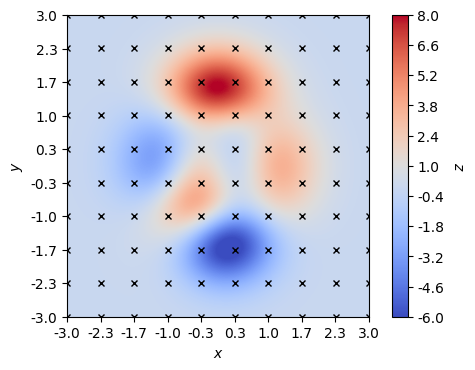

In [33]:
num_pts = 1000
x_vals = jnp.linspace(-3, 3, num_pts)
y_vals = jnp.linspace(-3, 3, num_pts)
x, y = jnp.meshgrid(x_vals, y_vals)
z = peaks(x,y)
plot_surface(x, y, z, z_lims=(-6,8), train_pts=[x_train,y_train])
plt.savefig(os.path.join(fig_save_dir, 'original_peaks.png'), dpi=mpl_save_dpi)

Create 'training' data:

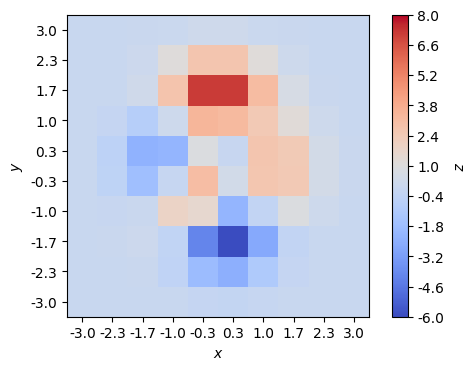

In [61]:
z_train = peaks(x_train,y_train)
plot_surface(x_train, y_train, z_train, z_lims=(-6,8))
plt.savefig(os.path.join(fig_save_dir, 'training_peaks.png'), dpi=mpl_save_dpi)

Train GP:

In [11]:
constraints = {"length_0": {">": 0.01, "<": 10}, 
               "length_1": {">": 0.01, "<": 10}, 
               "const": {">": 0.01, "<": 10}}
train_features = jnp.stack([x_train.flatten(), y_train.flatten()], axis=1)
train_labels = z_train.flatten()
gp = surrojax_gp.create_gp(kernel, train_features, train_labels, constraints)

1423091.4
1453246.0
749038.3
474335.66
180.66614
180.63516
180.51297
180.04205
178.42853
175.74368
175.59125
175.57047
175.54312
175.45479
175.24057
174.65842
173.0907
180.10681
171.99046
171.10455
169.10098
168.91298
168.88983
168.88953
168.88956
168.88959
168.88953
168.88953
168.88953
168.88956
168.88953
168.88953
168.88956
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
169.00726
168.88953
168.88956
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
168.88953
      fun: array(168.88952637)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.34222412e-03, -3.70689013e-05, -1.81350708e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 19
     njev: 57
   status: 0
  success: True
        x: array([2.94482753, 0.01000458, 0.4254145 ])
952225.5
222.28546
222.28525
222.28445
222.28119
222.26813
222.21585
221.99655
219.34125

# Gradient Predictions

In [35]:
features = jnp.stack([x.flatten(), y.flatten()], axis=1)

Gradient wrt x:

In [36]:
gp_dx = gp.predict(features, grad=({'idx':[0], 'order':1},))['mean'].reshape(num_pts,num_pts)
true_dx = grad_and_vmap(peaks, args=(0,))(x,y).reshape(num_pts,num_pts)

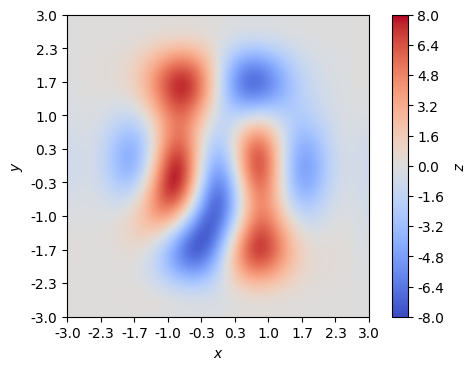

In [38]:
plot_surface(x, y, gp_dx, z_lims=(-8,8))
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dx.png'), dpi=mpl_save_dpi)

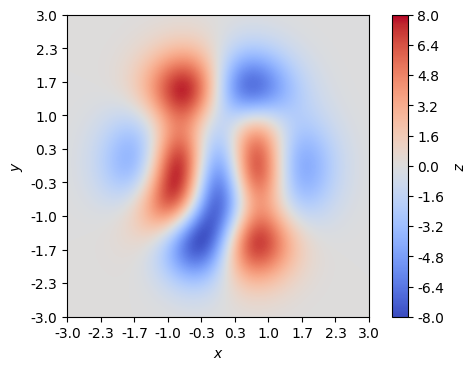

In [39]:
plot_surface(x, y, true_dx, z_lims=(-8,8))
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dx.png'), dpi=mpl_save_dpi)

Gradient wrt y:

In [40]:
gp_dy = gp.predict(features, grad=({'idx':[1], 'order':1},))['mean'].reshape(num_pts,num_pts)
true_dy = grad_and_vmap(peaks, args=(1,))(x,y).reshape(num_pts,num_pts)

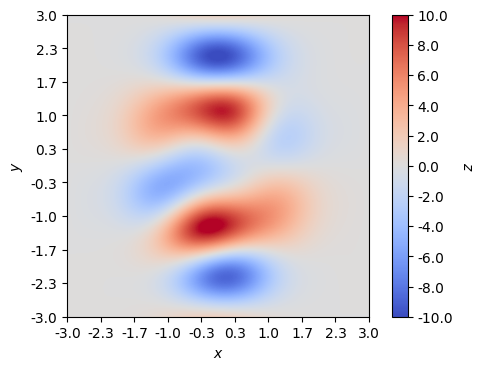

In [45]:
plot_surface(x, y, gp_dy, z_lims=(-10,10))
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dy.png'), dpi=mpl_save_dpi)

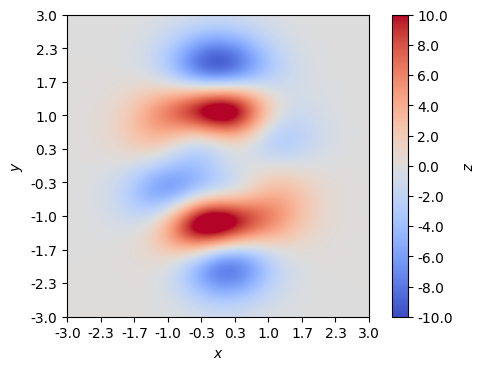

In [46]:
plot_surface(x, y, true_dy, z_lims=(-10,10))
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dy.png'), dpi=mpl_save_dpi)

Mixed gradient wrt x and y:

In [47]:
gp_dxdy = gp.predict(features, grad=({'idx':[0], 'order':1},{'idx':[1], 'order':1}))['mean'].reshape(num_pts,num_pts)
true_dxdy = grad_and_vmap(peaks, args=(0,1))(x,y).reshape(num_pts,num_pts)

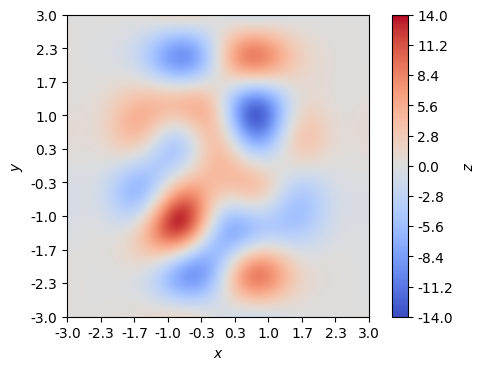

In [50]:
plot_surface(x, y, gp_dxdy, z_lims=(-14,14))
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dxdy.png'), dpi=mpl_save_dpi)

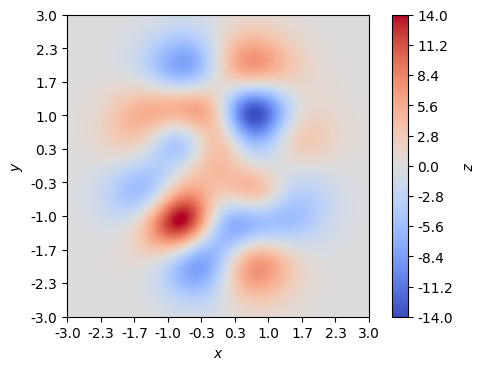

In [51]:
plot_surface(x, y, true_dxdy, z_lims=(-14,14))
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dxdy.png'), dpi=mpl_save_dpi)

Double gradient wrt x:

In [52]:
gp_dxdx = gp.predict(features, grad=({'idx':[0], 'order':1},{'idx':[0], 'order':1}))['mean'].reshape(num_pts,num_pts)
true_dxdx = grad_and_vmap(peaks, args=(0,0))(x,y).reshape(num_pts,num_pts)

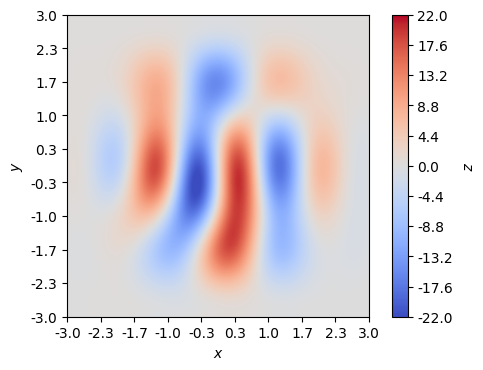

In [56]:
plot_surface(x, y, gp_dxdx, z_lims=(-22,22))
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dxdx.png'), dpi=mpl_save_dpi)

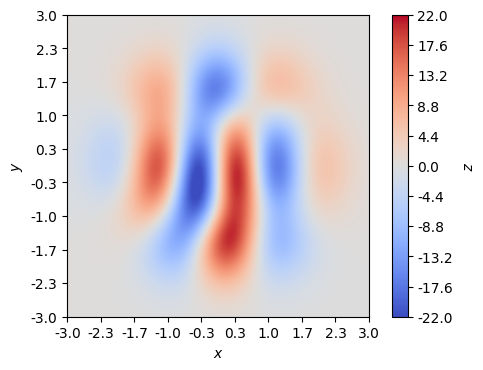

In [57]:
plot_surface(x, y, true_dxdx, z_lims=(-22,22))
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dxdx.png'), dpi=mpl_save_dpi)